In [ ]:
import pandas as pd

# Load the data from the provided CSV file
file_path = '/home/aster/short_term_proj/data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

In [ ]:
import matplotlib.pyplot as plt

# Filter data for Melbourne
city_name = "Melbourne"
city_data = data[data['city'] == city_name]

# Convert date to datetime format for better plotting
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')

# Plotting the trends for each sector
plt.figure(figsize=(14, 8))

for sector in city_data['sector'].unique():
    sector_data = city_data[city_data['sector'] == sector]
    plt.plot(sector_data['date'], sector_data['value'], label=sector)

plt.title(f'Emissions Trends for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

# Filter data for Melbourne
city_name = "Melbourne"
city_data = data[data['city'] == city_name].copy()

# Convert date to datetime format
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')

# Aggregate data by date and sum emissions from all sectors
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Create sequences for training (e.g., use past 60 days to predict the next day)
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(daily_data_scaled)):
    X_train.append(daily_data_scaled[i-sequence_length:i, 0])
    y_train.append(daily_data_scaled[i, 0])

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20)

# Preparing the test data for prediction (next 3 years, 1095 days)
test_input = daily_data_scaled[-sequence_length:]  # Start with the last 60 days of data
X_test = []

for i in range(1095):  # Predict for 1095 days (3 years)
    current_input = test_input[-sequence_length:].reshape(1, sequence_length, 1)
    pred_value = model.predict(current_input)
    X_test.append(pred_value[0][0])
    test_input = np.append(test_input, pred_value)[1:]  # Update the input sequence

# Inverse transform the predictions to the original scale
predicted_values = scaler.inverse_transform(np.array(X_test).reshape(-1, 1))

# Create a date range for the next 3 years
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=1095)

# Create a DataFrame with the predicted values
predicted_df = pd.DataFrame(predicted_values, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df.index, predicted_df['Predicted Emissions'], label='Predicted Emissions', color='red')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years)')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from keras.layers import SimpleRNN, GRU

# Define a Simple RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(units=50, return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(units=25))
rnn_model.add(Dense(units=1))

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the RNN model
rnn_model.fit(X_train, y_train, batch_size=32, epochs=20)

# Prepare the test data for prediction with the RNN model
test_input_rnn = daily_data_scaled[-sequence_length:]
X_test_rnn = []

for i in range(1095):  # Predict for 1095 days (3 years)
    current_input = test_input_rnn[-sequence_length:].reshape(1, sequence_length, 1)
    pred_value_rnn = rnn_model.predict(current_input)
    X_test_rnn.append(pred_value_rnn[0][0])
    test_input_rnn = np.append(test_input_rnn, pred_value_rnn)[1:]  # Update the input sequence

# Inverse transform the predictions to the original scale
predicted_values_rnn = scaler.inverse_transform(np.array(X_test_rnn).reshape(-1, 1))

# Create a DataFrame with the predicted values
predicted_df_rnn = pd.DataFrame(predicted_values_rnn, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions with RNN model
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df_rnn.index, predicted_df_rnn['Predicted Emissions'], label='Predicted Emissions (RNN)', color='green')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - RNN Model')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Combine external features
city_name = "Melbourne"
city_data = data[data['city'] == city_name].copy()
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
city_data['day_of_year'] = city_data['date'].dt.dayofyear
city_data['month'] = city_data['date'].dt.month

# Aggregate the data by day
daily_data = city_data.groupby('date')['value'].sum().reset_index()

# Add external features
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
daily_data['month'] = daily_data['date'].dt.month

# Normalize the carbon emission data
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data_scaled = scaler.fit_transform(daily_data[['value']])

# Combine the normalized emissions with external features
features = np.concatenate([
    daily_data_scaled,
    daily_data[['day_of_year', 'month']].values
], axis=1)

# Prepare the data for GRU input (using sequences of 60 days)
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(features)):
    X_train.append(features[i-sequence_length:i, :])
    y_train.append(features[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Build the GRU model with external features
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=25))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, batch_size=32, epochs=20)

# Prepare test data for prediction
test_input_gru = features[-sequence_length:]  # Start with the last 60 days of data
X_test_gru = []

for i in range(1095):  # Predict for 1095 days (3 years)
    current_input = test_input_gru[-sequence_length:].reshape(1, sequence_length, X_train.shape[2])
    pred_value_gru = gru_model.predict(current_input)
    X_test_gru.append(pred_value_gru[0][0])

    # Update the input sequence with predicted value and external features
    next_day = (test_input_gru[-1, 1:] + [1, 1]) % [365, 12]  # Increment day and month
    next_input = np.concatenate([[pred_value_gru[0][0]], next_day], axis=0)
    test_input_gru = np.vstack([test_input_gru, next_input])[1:]

# Inverse transform the predicted values to the original scale
predicted_values_gru = scaler.inverse_transform(np.array(X_test_gru).reshape(-1, 1))

# Create a DataFrame with the predicted values
future_dates = pd.date_range(start=daily_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=1095)
predicted_df_gru = pd.DataFrame(predicted_values_gru, index=future_dates, columns=['Predicted Emissions'])

# Plotting the predicted emissions with GRU model
plt.figure(figsize=(14, 8))
plt.plot(daily_data['date'], daily_data['value'], label='Historical Emissions')
plt.plot(predicted_df_gru.index, predicted_df_gru['Predicted Emissions'], label='Predicted Emissions (GRU with External Features)', color='purple')
plt.title('Daily Carbon Emissions Prediction for Melbourne (Next 3 Years) - GRU Model with External Features')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


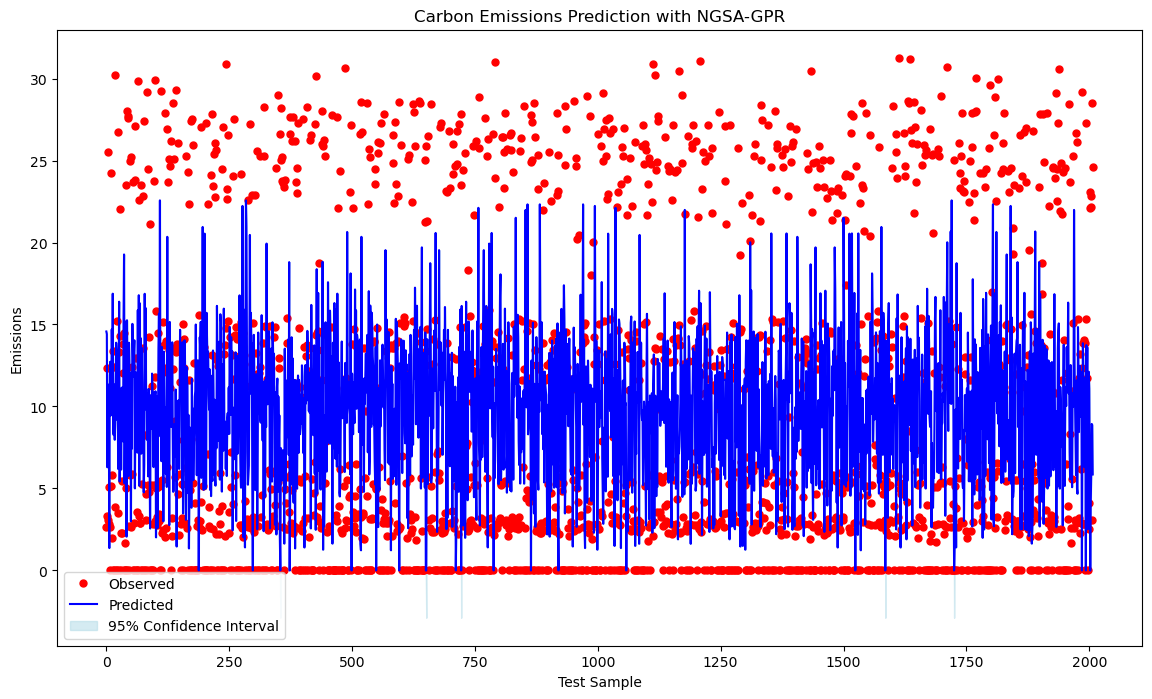

In [8]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 生成非高斯分布的扩展特征（如多项式扩展）
def non_gaussian_state_augmentation(X, degree=2):
    poly = PolynomialFeatures(degree)
    X_augmented = poly.fit_transform(X)
    return X_augmented

# 使用日期数据和其他特征作为输入
city_name = "Melbourne"
city_data = data[data['city'] == city_name].copy()

# 将日期转换为时间戳，生成多项式特征
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')
X = city_data[['timestamp']].values

# 使用NGSA进行状态扩展
X_augmented = non_gaussian_state_augmentation(X, degree=3)

# 目标变量为碳排放量
y = city_data['value'].values

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y, test_size=0.2, random_state=42)

# 构建高斯过程回归模型，使用RBF核
kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 训练模型
gpr.fit(X_train, y_train)

# 预测未来碳排放
y_pred, sigma = gpr.predict(X_test, return_std=True)

# 绘制预测结果与实际值的对比
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, 'r.', markersize=10, label='Observed')
plt.plot(range(len(y_pred)), y_pred, 'b-', label='Predicted')
plt.fill_between(range(len(y_pred)), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.5, color='lightblue', label='95% Confidence Interval')
plt.title('Carbon Emissions Prediction with NGSA-GPR')
plt.xlabel('Test Sample')
plt.ylabel('Emissions')
plt.legend()
plt.show()
